In [19]:
import warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings(action="ignore",category=DeprecationWarning)
warnings.filterwarnings(action="ignore",category=FutureWarning)
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import tensorflow as tf
import os
import math
import gc
import copy
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from datetime import datetime


from keras.layers import Dense, Input, Activation
from keras.layers import BatchNormalization,Add,Dropout
from keras.optimizers import Adam
from keras.models import Model, load_model
from keras import callbacks
from keras import backend as K

In [32]:
def create_nn_model(input_shape):
    inp = Input(shape=(input_shape,))
    x = Dense(2048, activation="relu")(inp)
    x = BatchNormalization()(x)
    #x = Dropout(0.4)(x)
    for i in range(4):
        x = Dense(1024, activation="relu")(x)
        x = BatchNormalization()(x)
    x = Dense(512, activation="relu")(x)
    x = BatchNormalization()(x)
    x = Dense(512, activation="relu")(x)
    x = BatchNormalization()(x)
    out = Dense(1, activation="linear")(x)  
   # out1 = Dense(2, activation="linear")(x)#mulliken charge 2
   # out2 = Dense(6, activation="linear")(x)#tensor 6(xx,yy,zz)
   # out3 = Dense(12, activation="linear")(x)#tensor 12(others) 
   # out4 = Dense(1, activation="linear")(x)#scalar_coupling_constant 
    #model = Model(inputs=inp, outputs=[out,out1,out2,out3,out4])
    model = Model(inputs=inp, outputs=[out])
    return model

In [3]:
def plot_history(history, label):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Loss for %s' % label)
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    _= plt.legend(['Train','Validation'], loc='upper left')
    plt.show()

In [4]:
# Set up GPU preferences
config = tf.ConfigProto( device_count = {'GPU': 1 , 'CPU': 2} ) 
config.gpu_options.allow_growth = True
config.gpu_options.per_process_gpu_memory_fraction = 0.6
sess = tf.Session(config=config) 
K.set_session(sess)

In [9]:
csv_file_folder =  '../../data/input'
file_folder =  '../../data/feature'

In [10]:
train_csv = pd.read_csv(f'{csv_file_folder}/train.csv')

In [21]:
test_csv = pd.read_csv(f'{csv_file_folder}/test.csv')

In [11]:
mol_types=train_csv["type"].unique()

In [13]:
mol_types

array(['1JHC', '2JHH', '1JHN', '2JHN', '2JHC', '3JHH', '3JHC', '3JHN'],
      dtype=object)

In [12]:
type_columns = [['tertiary_angle_0', 'inv_dist1R', 'd_4_3', 'yukawa_H.y', 'mulliken_atom_0', 'dist_to_type_mean', 'dist_O_0_x', 'atom_1_n_bonds', 'dist_to_type_1_mean', 'atom_1_bond_lengths_mean', 'dist_xyz', 'dist_C_0_y', 'd_3_2', 'atom_index_1_ hybridization', 'atom_index_1_cycle_size_mean', 'dist_O_0_y', 'eem_1', 'inv_distPE', 'd_4_2', 'inv_distPR', 'dist_no_bond_min_y', 'dist_H_2_x', 'dist_H_1_x', 'tertiary_distance_2', 'dist_C_3_x', 'dist_O_1_x', 'atom_1_bond_lengths_std', 'dist_C_2_y', 'dist_C_2_x', 'mulliken_atom_1', 'cos_center1', 'dist_O_1_y', 'tertiary_angle_3', 'dist_H_2_y', 'dist_N_0_y', 'dist_C_1_y', 'inv_dist1E', 'distance_y', 'tertiary_angle_2', 'dist_N_0_x', 'd_2_1', 'molecule_atom_index_0_dist_max_div', 'adC1', 'adN1', 'd_4_0', 'dist_C_3_y', 'atom_3', 'distC0', 'tertiary_distance_4', 'tertiary_angle_5', 'd_5_1', 'molecule_atom_index_1_dist_min_diff', 'dist_C_4_y', 'dist_H_0_y', 'cos_f0', 'd_5_0', 'tertiary_distance_3', 'd_5_2', 'tertiary_atom_1', 'dist_C_4_x', 'cos_c0_f0', 'atom_index_0_sv_3', 'rc_C', 'cos_f1', 'tertiary_angle_8', 'dist_O_2_y', 'max_molecule_atom_1_dist_xyz', 'dist_F_0_y', 'atom_index_1_ aromatic', 'tertiary_angle_26', 'type_0'],
['dist_H_0_y', 'd_3_2', 'dist_C_0_y', 'atom_index_1_ aromatic', 'atom_1_bond_lengths_mean', 'bond_atom', 'inv_dist1R', 'd_3_1', 'mulliken_atom_0', 'dist_H_0_x', 'dist_O_0_y', 'dist_C_1_x', 'tertiary_angle_0', 'dist_C_1_y', 'vander_C.y', 'dist_H_1_y', 'mulliken_atom_1', 'inv_dist0R', 'd_1_0', 'tertiary_distance_0', 'tertiary_angle_2', 'atom_index_1_explicit_valence', 'dist_N_0_y', 'inv_distPR', 'dist_C_2_x', 'vander_H.x', 'd_4_2', 'atom_index_0_eigv_max', 'tertiary_distance_2', 'dist_H_1_x', 'dist_N_1_x', 'dist_C_3_x', 'cos_f0', 'atom_index_1_sv_2', 'max_molecule_atom_0_dist_xyz', 'd_2_1'],
['tertiary_atom_0', 'inv_dist0', 'dist_no_bond_min_x', 'atom_index_1_ hybridization', 'tertiary_angle_0', 'tertiary_angle_1', 'dist_O_0_x', 'cos_c0', 'd_5_2', 'tertiary_atom_1', 'cos_f0', 'dist_H_0_x', 'd_3_1', 'atom_index_1_degree', 'dist_C_0_y', 'adC2', 'dist_C_3_x', 'vander_O.y', 'mulliken_atom_1', 'atom_7', 'tertiary_angle_2', 'd_2_1', 'atom_3', 'd_5_1', 'd_6_2', 'd_4_1', 'tertiary_atom_2', 'molecule_atom_index_1_dist_min_diff', 'd_4_2', 'dist_C_2_x', 'cos_c0_f0', 'd_6_0', 'dist_O_0_y', 'd_4_3', 'd_3_0', 'd_7_0', 'd_3_2', 'inv_dist0R', 'atom_8', 'dist_C_1_x', 'd_6_1', 'd_2_0', 'd_8_1', 'mulliken_atom_0', 'dist_N_0_x', 'atom_4', 'tertiary_distance_2', 'd_7_2', 'dist_C_0_x', 'atom_1_bond_lengths_mean', 'dist_C_1_y', 'bond_atom', 'd_7_1', 'd_4_0', 'distC0', 'atom_index_1_cycle_size_mean', 'cos_c0_c1', 'tertiary_angle_3', 'dist_O_1_x', 'atom_index_1_n_cycle', 'max_molecule_atom_0_dist_xyz', 'molecule_atom_index_0_dist_max_div', 'atom_5', 'gap', 'cos_c1', 'dist_N_0_y', 'd_6_3', 'dist_C_3_y', 'inv_distP', 'dist_C_4_y'],
['cos_c0', 'd_4_3', 'cos_c0_c1', 'molecule_atom_index_0_dist_min_diff', 'tertiary_atom_1', 'd_3_2', 'd_1_0', 'dist_H_0_y', 'mulliken_atom_0', 'mulliken_atom_1', 'dist_N_0_x', 'link0', 'tertiary_atom_2', 'dist_C_1_y', 'dist_C_1_x', 'cos_f0', 'dist_C_0_y', 'cos_f1', 'd_3_1', 'tertiary_distance_1', 'dist_O_0_y', 'cos_f0_f1', 'adC1', 'd_5_3', 'inv_distP', 'edge_4', 'd_6_2', 'dist_N_0_y', 'tertiary_distance_2', 'dist_O_0_x', 'cos_c1_f1', 'd_3_0', 'd_5_2', 'dist_C_0_x', 'adN1', 'cos_c0_f0', 'd_4_1', 'max_distance_y', 'dist_C_2_y', 'atom_5', 'adC3', 'dist_to_type_1_mean', 'vander_H.x', 'dist_C_3_y', 'dist_H_3_x', 'molecule_atom_index_0_dist_max_div', 'atom_7', 'dist_C_3_x', 'd_5_1', 'dist_H_3_y', 'atom_index_0_eigv_max', 'atom_6', 'dist_H_2_x', 'atom_index_1_sv_0', 'molecule_atom_index_1_dist_std_div', 'link1'],
['d_3_1', 'dist_H_1_x', 'd_5_0', 'd_4_0', 'yukawa_H.x', 'inv_dist0', 'd_6_0', 'd_4_1', 'cos_c0', 'atom_3', 'dist_C_0_y', 'molecule_atom_index_0_dist_std_div', 'cos_c0_c1', 'd_4_2', 'min_molecule_atom_0_dist_xyz', 'sd_molecule_atom_0_dist_xyz', 'd_2_1', 'adC2', 'd_3_0', 'dist_C_1_y', 'd_4_3', 'dist_H_0_x', 'vander_C.x', 'd_5_3', 'dist_H_1_y', 'tertiary_distance_3', 'd_2_0', 'dist_O_0_x', 'd_5_1', 'dist_O_0_y', 'adC3', 'inv_dist0R', 'dist_C_3_y', 'atom_index_1_ hybridization', 'cos_f0', 'dist_C_2_x', 'd_5_2', 'd_6_1', 'dist_C_0_x', 'atom_1_bond_lengths_min', 'mulliken_atom_1', 'distance_farthest_0', 'tertiary_distance_1', 'min_molecule_atom_1_dist_xyz', 'yukawa_O.y', 'atom_0_bond_lengths_max'],
['tertiary_angle_0', 'd_2_1', 'cos_c0', 'atom_1_bond_lengths_mean', 'd_3_1', 'd_2_0', 'tertiary_distance_1', 'd_3_2', 'tertiary_angle_1', 'cos_f0', 'tertiary_distance_2', 'dist_C_0_x', 'dist_H_0_x', 'dist_C_2_x', 'dist_O_0_y', 'd_4_1', 'd_4_3', 'atom_index_1_cycle_size_mean', 'molecule_atom_index_0_dist_min_diff', 'tertiary_atom_2', 'atom_4', 'cos_c0_f0', 'tertiary_distance_3', 'd_3_0', 'dist_median_bond_y', 'd_5_2', 'adC3', 'atom_5', 'dist_H_1_x', 'molecule_atom_index_0_dist_min_div', 'gap', 'molecule_atom_index_1_dist_min_div', 'dist_O_0_x', 'cos_c1', 'dist_C_0_y', 'd_5_1', 'dist_N_0_y', 'dist_C_3_y', 'dist_no_bond_min_y', 'd_4_0', 'dist_N_0_x', 'd_4_2', 'max_molecule_atom_0_dist_xyz', 'cos_c0_c1', 'adC2', 'atom_index_1_n_cycle', 'd_5_0', 'd_6_1', 'dist_C_4_y', 'dist_O_1_y', 'd_7_2', 'tertiary_angle_2', 'd_6_2', 'mulliken_atom_1', 'atom_6', 'd_7_3', 'dist_O_1_x'],
['cos_c0_c1', 'atom_4', 'atom_5', 'molecule_atom_index_0_dist_min_diff', 'cos_c1', 'max_molecule_atom_1_dist_xyz', 'dist_to_type_std', 'd_3_2', 'cos_c0', 'dist_O_0_x', 'd_4_3', 'atom_6', 'dist_O_0_y', 'tertiary_atom_1', 'dist_C_2_y', 'd_4_2', 'dist_C_1_y', 'atom_7', 'tertiary_angle_1', 'dist_H_0_y', 'dist_no_bond_min_y', 'distance_c1', 'dist_C_2_x', 'linkM0', 'd_6_2', 'dist_C_0_y', 'd_5_2', 'd_7_2', 'dist_C_3_y', 'd_6_0', 'dihedral', 'max_molecule_atom_0_dist_xyz', 'd_7_3', 'd_6_1', 'dist_H_1_y', 'tertiary_atom_2', 'd_4_0', 'tertiary_atom_0', 'tertiary_angle_3', 'dist_C_0_x', 'dist_to_type_0_mean', 'dist_N_0_y', 'd_4_1', 'cos_c1_f1', 'cos_f0', 'dist_xyz', 'adC2', 'd_5_3', 'cos_f0_f1', 'gap', 'd_7_0', 'cos_f1', 'tertiary_distance_1', 'molecule_atom_index_0_dist_max_diff', 'd_2_1'],
['cos_c0', 'tertiary_distance_1', 'cos_c1', 'd_3_2', 'tertiary_angle_1', 'tertiary_angle_0', 'atom_1_n_bonds', 'tertiary_distance_2', 'd_2_1', 'tertiary_angle_2', 'd_4_0', 'molecule_atom_index_0_dist_min_div', 'd_2_0', 'dist_H_0_x', 'd_3_1', 'cos_c0_c1', 'mulliken_atom_1', 'd_8_3', 'd_4_1', 'dist_C_0_y', 'd_3_0', 'atom_index_1_cycle_size_mean', 'dist_C_1_x', 'dist_C_2_x', 'adC2', 'adC1', 'atom_1_bond_lengths_std', 'atom_index_1_n_cycle', 'd_4_2', 'cos_f0', 'd_5_2', 'dist_to_type_0_mean', 'dist_O_0_x', 'molecule_atom_index_0_dist_std_diff', 'd_5_1', 'tertiary_angle_3', 'd_6_2', 'd_7_3']]

In [14]:
df_train_ = pd.read_pickle(f'{file_folder}/df_train2.gzde', compression='gzip')
df_train__plus = pd.read_pickle(f'{file_folder}/df_train2_plus.gzde', compression='gzip')
df_train__plus = df_train__plus.rename(columns={'id':'index'})
df_train_ = pd.merge(df_train_, df_train__plus, how='left', on='index')
df_train_ = df_train_.fillna(0)

df_test_ = pd.read_pickle(f'{file_folder}/df_test2.gzde', compression='gzip')
df_test__plus = pd.read_pickle(f'{file_folder}/df_test2_plus.gzde', compression='gzip')
df_test__plus = df_test__plus.rename(columns={'id':'index'})
df_test_ = pd.merge(df_test_, df_test__plus, how='left', on='index')
df_test_ = df_test_.fillna(0)

In [23]:
type_list = df_train_.type.unique().tolist()

In [29]:
retrain =True
cv_score=[]
cv_score_total=0
epoch_n = 1000
verbose = 1
batch_size = 2048

Training 0 out of ['1JHC' '2JHH' '1JHN' '2JHN' '2JHC' '3JHH' '3JHC' '3JHN'] 

Train on 3726517 samples, validate on 931630 samples
Epoch 1/1000
3726517/3726517 [==============================] - 118s 32us/step - loss: 1.9703 - val_loss: 2.3424
Epoch 2/1000
3726517/3726517 [==============================] - 115s 31us/step - loss: 1.0876 - val_loss: 1.2276
Epoch 3/1000
3726517/3726517 [==============================] - 115s 31us/step - loss: 1.0156 - val_loss: 1.2131
Epoch 4/1000
3726517/3726517 [==============================] - 115s 31us/step - loss: 0.9721 - val_loss: 0.7531
Epoch 5/1000
3726517/3726517 [==============================] - 115s 31us/step - loss: 0.9311 - val_loss: 1.0327
Epoch 6/1000
3726517/3726517 [==============================] - 115s 31us/step - loss: 0.8982 - val_loss: 0.8051
Epoch 7/1000
3726517/3726517 [==============================] - 115s 31us/step - loss: 0.8942 - val_loss: 1.1432
Epoch 8/1000
3726517/3726517 [==============================] - 115s 31us/step

Epoch 72/1000
3726517/3726517 [==============================] - 114s 31us/step - loss: 0.7194 - val_loss: 0.4206
Epoch 73/1000
3726517/3726517 [==============================] - 114s 31us/step - loss: 0.7187 - val_loss: 0.4660
Epoch 74/1000
3726517/3726517 [==============================] - 114s 31us/step - loss: 0.7354 - val_loss: 0.3708
Epoch 75/1000
3726517/3726517 [==============================] - 114s 31us/step - loss: 0.7300 - val_loss: 0.4764
Epoch 76/1000
3726517/3726517 [==============================] - 114s 31us/step - loss: 0.7262 - val_loss: 0.3824
Epoch 77/1000
3726517/3726517 [==============================] - 114s 31us/step - loss: 0.7202 - val_loss: 0.3376
Epoch 78/1000
3726517/3726517 [==============================] - 114s 31us/step - loss: 0.7296 - val_loss: 0.4027
Epoch 79/1000
3726517/3726517 [==============================] - 114s 31us/step - loss: 0.6962 - val_loss: 0.3500
Epoch 80/1000
3726517/3726517 [==============================] - 114s 31us/step - loss: 

3726517/3726517 [==============================] - 115s 31us/step - loss: 0.6524 - val_loss: 0.2694
Epoch 230/1000
3726517/3726517 [==============================] - 115s 31us/step - loss: 0.6499 - val_loss: 0.2709
Epoch 231/1000
3726517/3726517 [==============================] - 115s 31us/step - loss: 0.6406 - val_loss: 0.2701
Epoch 232/1000
3726517/3726517 [==============================] - 115s 31us/step - loss: 0.6541 - val_loss: 0.2668
Epoch 233/1000
3726517/3726517 [==============================] - 115s 31us/step - loss: 0.6389 - val_loss: 0.2671
Epoch 234/1000
3726517/3726517 [==============================] - 115s 31us/step - loss: 0.6188 - val_loss: 0.2650
Epoch 235/1000
3726517/3726517 [==============================] - 124s 33us/step - loss: 0.6424 - val_loss: 0.2653
Epoch 236/1000
3726517/3726517 [==============================] - 115s 31us/step - loss: 0.6358 - val_loss: 0.2678
Epoch 237/1000
3726517/3726517 [==============================] - 115s 31us/step - loss: 0.6297

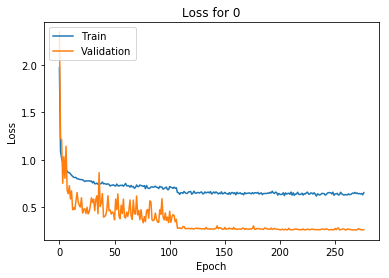

-1.3353677708388292


ValueError: NumPy boolean array indexing assignment cannot assign 2505542 input values to the 0 output values where the mask is true

In [33]:
start_time=datetime.now()
test_prediction=np.zeros(len(test_csv))



# Loop through each molecule type
for mol_type in type_list:

    model_name_wrt = ('molecule_model_%s.hdf5' % mol_type)
    print('Training %s' % mol_type, 'out of', mol_types, '\n')
    
#     full = build_couple_dataframe(train_csv, structures_csv, mol_type, n_atoms=11)
#     full2 = build_couple_dataframe(test_csv, structures_csv, mol_type, n_atoms=11)
#     df_train_ = take_n_atoms(full, 11)
#     df_test_ = take_n_atoms(full2, 11)
#     df_train_  = df_train_.fillna(0)
#     df_test_  = df_test_.fillna(0)
    
#     # Standard Scaler from sklearn does seem to work better here than other Scalers
#     input_data=StandardScaler().fit_transform(pd.concat([df_train_.loc[:,input_features],df_test_.loc[:,input_features]]))   
#     #input_data=StandardScaler().fit_transform(df_train_.loc[:,input_features])
#     target_data=df_train_.loc[:,"scalar_coupling_constant"].values
    
    input_data=StandardScaler().fit_transform(pd.concat([df_train_.loc[:,type_columns[mol_type]],
                                                         df_test_.loc[:,type_columns[mol_type]]]))   
    target_data=df_train_.loc[:,"scalar_coupling_constant"].values
    
    # Simple split to provide us a validation set to do our CV checks with
    train_index, cv_index = train_test_split(np.arange(len(df_train_)),random_state=111, test_size=0.2)
    # Split all our input and targets by train and cv indexes
    train_target=target_data[train_index]
    cv_target=target_data[cv_index]
    train_input=input_data[train_index]
    cv_input=input_data[cv_index]
    test_input=input_data[len(df_train_):,:]

    # Build the Neural Net
    nn_model=create_nn_model(train_input.shape[1])
    
    # If retrain==False, then we load a previous saved model as a starting point.
    if not retrain:
        nn_model = load_model(model_name_rd)
        
    nn_model.compile(loss='mae', optimizer=Adam())#, metrics=[auc])
    
    # Callback for Early Stopping... May want to raise the min_delta for small numbers of epochs
    es = callbacks.EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=40,verbose=1, mode='auto', restore_best_weights=True)
    # Callback for Reducing the Learning Rate... when the monitor levels out for 'patience' epochs, then the LR is reduced
    rlr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1,patience=30, min_lr=1e-6, mode='auto', verbose=1)
    # Save the best value of the model for future use
    sv_mod = callbacks.ModelCheckpoint(model_name_wrt, monitor='val_loss', save_best_only=True, period=1)
    history = nn_model.fit(train_input,[train_target], 
            validation_data=(cv_input,[cv_target]), 
            callbacks=[es, rlr, sv_mod], epochs=epoch_n, batch_size=batch_size, verbose=verbose)
    
    cv_predict=nn_model.predict(cv_input)
    plot_history(history, mol_type)
    accuracy=np.mean(np.abs(cv_target-cv_predict[:,0]))
    print(np.log(accuracy))
    cv_score.append(np.log(accuracy))
    cv_score_total+=np.log(accuracy)
    
    # Predict on the test data set using our trained model
    test_predict=nn_model.predict(test_input)
    
    # for each molecule type we'll grab the predicted values
    test_csv[test_csv["type"]==mol_type]=test_predict[:,0]
    K.clear_session()
    break

cv_score_total/=len(mol_types)

In [34]:
test_csv[test_csv["type"]==mol_type].head()

,id,molecule_name,atom_index_0,atom_index_1,type


In [36]:
test_csv.type.value_counts()

3JHC    811999
2JHC    613138
1JHC    380609
3JHH    317435
2JHH    203126
3JHN     90616
2JHN     64424
1JHN     24195
Name: type, dtype: int64